# Assessing auto-differentiation speed improvement

This notebook aims to have a feeling on the speedup that can be brought by replacing classical gradient descent algorithms used in `SLITronomy` by an auto-differentiation scheme.

We wish to assess the feasability and usefulness of rewriting the loss function designed for the SLIT algorithm in a `TensorFlow` formalism, through a simple test case and timing of function evaluations.

In [1]:
__author__ = 'aymgal', 'austinpeel'
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import pysap

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.plot_util import nice_colorbar

%matplotlib inline

# =========

# type of lensing operator
lensing_operator = 'interpol'  # 'interpol' or 'simple'

# number of times to subdivide source plane grid
subgrid_res_source = 2

# starlets scales
n_scales_source = 6
n_scales_lens_light = 6

# compute and reduce source plane to minimal size
minimal_source_plane = False

# use the image mask computed through noise threshold
use_threshold_mask = False

# =========

In [25]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

## Generate a mock lens

In [2]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel
#exp_time = 400  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 41

In [3]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

(41, 41) (83, 83)


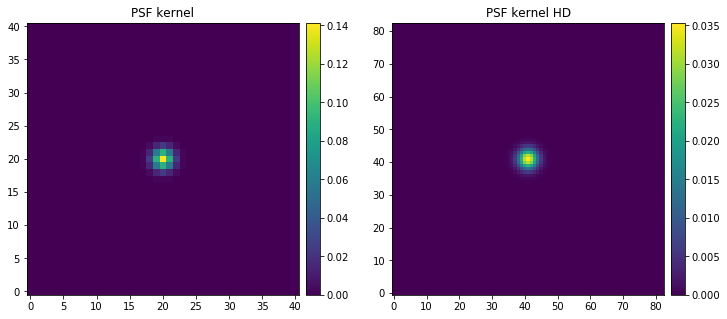

In [4]:
# PSF specification
psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
psf_num_pix_hd = int(np.ceil(psf_num_pix * subgrid_res_source) // 2 * 2 + 1)  # Round up to nearest odd number
psf_kernel_hd = kernel_util.kernel_gaussian(psf_num_pix_hd, delta_pix / subgrid_res_source, psf_fwhm)
print(psf_kernel.shape, psf_kernel_hd.shape)

kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF(**kwargs_psf)
kwargs_psf_hd = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel_hd}
psf_class_hd = PSF(**kwargs_psf_hd)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
im_psf = ax1.imshow(psf_class.kernel_point_source, origin='lower')
ax1.set_title("PSF kernel")
nice_colorbar(im_psf)
im_psf_hd = ax2.imshow(psf_class_hd.kernel_point_source, origin='lower')
ax2.set_title("PSF kernel HD")
nice_colorbar(im_psf_hd)
plt.show()

In [5]:
# list of lens mass model profiles
lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [{'amp': 80, 'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                  'center_x': 0.1, 'center_y': 0.2}]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [{'amp': 10, 'R_sersic': 2, 'n_sersic': 3, 'e1': -0.2, 'e2': 0.1,
                      'center_x': 0, 'center_y': 0}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

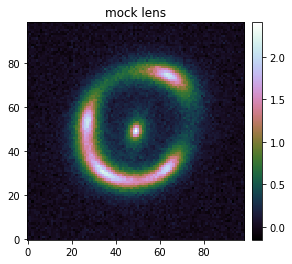

In [6]:
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

plt.title("mock lens")
im = plt.imshow(image_sim, origin='lower', cmap='cubehelix')
nice_colorbar(im)
plt.show()

## Setup sparse optimizazion

In [7]:
source_model_list_sparsefit = ['STARLETS']
kwargs_starlets_source = {'n_scales': n_scales_source, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}  # add center_x/center_y
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

lens_light_model_list_sparsefit = ['STARLETS']
kwargs_starlets_lens_light = {'n_scales': n_scales_lens_light, 'n_pixels': np.size(image_sim)}  # add center_x/center_y
kwargs_lens_light_sparsefit = [kwargs_starlets_lens_light]
lens_light_model_class_sparsefit = LightModel(light_model_list=lens_light_model_list_sparsefit)

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

if use_threshold_mask:
    likelihood_mask = image_mask.astype(bool)
else:
    likelihood_mask = None

kwargs_sparse_solver = {
    'lensing_operator': lensing_operator,  # 'simple' or 'interpol'
    
    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': minimal_source_plane,
    'min_num_pix_source': 69,
    
    'formulation': 'analysis',
    'initial_guess_type': 'noise_map',  # or 'background_rms' for just initializing with gaussian noise
    'force_positivity': True,
    'sparsity_prior_norm': 1,
    'max_threshold': 5,
    'max_threshold_high_freq': 10,
    #'num_iter': 100,  # when only source
    'num_iter_source': 100,
    'num_iter_lens': 100,
    'num_iter_weights': 1,
    'verbose': True,
    'show_steps': True,
}

imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                lens_light_model_class=lens_light_model_class_sparsefit,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)

## Timings of current implementation

In [8]:
# we can isolate the solver object
solver = imageSparseFit.sparseSolver

sourcePlane = solver.lensingOperator.sourcePlane
imagePlane = solver.lensingOperator.imagePlane
grid_offset_x = kwargs_special_sparsefit.get('delta_x_source_grid', 0)
grid_offset_y = kwargs_special_sparsefit.get('delta_y_source_grid', 0)
print(grid_offset_x, grid_offset_y)

0 0


### Compute lensing operator

In [9]:
# update manually the lensing operator
start = time.time()
solver.lensingOperator.update_mapping(kwargs_lens, kwargs_special_sparsefit)
end = time.time()
print("Lensing operator building took {:e} s".format(end - start))

# Note that this operation can hardly be cast in `tensforflow` but who knows?

Lensing operator building took 5.735330e+00 s


In [10]:
# some random source and (convolved) lens light estimates
S = np.random.rand(num_pix * subgrid_res_source, num_pix * subgrid_res_source)
HG = np.random.rand(num_pix, num_pix)

### Call to the loss function

In [11]:
print("Calling the loss function")
%timeit solver.loss(S=S, HG=HG)

Calling the loss function
441 µs ± 5.17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Call to the gradient

In [12]:
print("Calling grad(loss) wrt source")
%timeit solver.gradient_loss_source(S)

print("\nCalling grad(loss) wrt lens")
%timeit solver.gradient_loss_lens(HG)

Calling grad(loss) wrt source
942 µs ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Calling grad(loss) wrt lens
9.37 µs ± 236 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# Comparison with `TensorFlow`'s auto-differentiation

In [13]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [14]:
class TensorModelOperators(object):
    def __init__(self, lensModel, kwargs_lens, imagePlane, sourcePlane, psf_kernel, 
                 grid_offset_x=0, grid_offset_y=0):
        """Class for tensor lensing operations."""
        self.imagePlane = imagePlane
        self.sourcePlane = sourcePlane
        nx_psf, ny_psf = psf_kernel.shape
        self.psf_kernel = tf.reshape(psf_kernel, (nx_psf, ny_psf, 1, 1))
        self.lensing_matrix = self.build_lensing_matrix(lensModel, kwargs_lens, self.imagePlane, self.sourcePlane,
                                                        grid_offset_x, grid_offset_y)
        # Compute norm of the mapping for gradient calculation
        norm_1d = tf.maximum(tf.ones(self.sourcePlane.grid_size, dtype=self.lensing_matrix.dtype), 
                             tf.sparse.reduce_sum(self.lensing_matrix, axis=0))
        norm_2d = tf.reshape(norm_1d, S_tf.shape)
        self.norm = 1 / norm_2d

    def build_lensing_matrix(self, lensModel, kwargs_lens, imagePlane, sourcePlane, 
                             grid_offset_x, grid_offset_y):
        """All-in-one version of the method described in the fast_lensing_matrix notebook."""
        # Compute lens mapping from image to source coordinates
        beta_x, beta_y = lensModel.ray_shooting(imagePlane.theta_x, imagePlane.theta_y, kwargs_lens)
        
        # Standardize inputs for vectorization
        beta_x = np.atleast_1d(beta_x)
        beta_y = np.atleast_1d(beta_y)

        # Shift source grid as necessary
        source_theta_x = sourcePlane.theta_x + grid_offset_x
        source_theta_y = sourcePlane.theta_y + grid_offset_y

        # Compute bin edges so that (theta_x, theta_y) lie at the centers
        half_pix = sourcePlane.delta_pix / 2

        theta_x = source_theta_x[:sourcePlane.num_pix]
        xbins = np.linspace(theta_x[0] - half_pix, theta_x[-1] + half_pix, sourcePlane.num_pix + 1)
        index_x = np.digitize(beta_x, xbins) - 1

        theta_y = source_theta_y[::sourcePlane.num_pix]
        ybins = np.linspace(theta_y[0] - half_pix, theta_y[-1] + half_pix, sourcePlane.num_pix + 1)
        index_y = np.digitize(beta_y, ybins) - 1

        # Find the (1D) source plane pixel that (beta_x, beta_y) falls in
        index_1 = index_x + index_y * sourcePlane.num_pix

        # Compute distances between ray-traced betas and source grid points
        dx = beta_x - source_theta_x[index_1]
        dy = beta_y - source_theta_y[index_1]

        # Find the three other nearest pixels
        index_2 = index_1 + np.sign(dx).astype(int)
        index_3 = index_1 + np.sign(dy).astype(int) * sourcePlane.num_pix
        index_4 = index_2 + np.sign(dy).astype(int) * sourcePlane.num_pix

        # Gather indices (sorted for correct SparseTensor ordering)
        indices = np.sort([index_1, index_2, index_3, index_4], axis=0).T.flat

        # Compute weights like in Treu & Koopmans (2004)
        dist_x = (np.repeat(beta_x, 4) - source_theta_x[indices]) / sourcePlane.delta_pix
        dist_y = (np.repeat(beta_y, 4) - source_theta_y[indices]) / sourcePlane.delta_pix
        weights = (1. - np.abs(dist_x)) * (1. - np.abs(dist_y))

        # Construct 2D indices for use in build_lensing_matrix
        indices = (np.repeat(np.arange(imagePlane.grid_size), 4), indices)

        # Build lensing matrix either as a sparse tensor or csr matrix
        dense_shape = (imagePlane.grid_size, sourcePlane.grid_size)
        lensing_matrix = tf.sparse.SparseTensor(indices=np.column_stack(indices), 
                                                values=weights, dense_shape=dense_shape)

        return lensing_matrix
    
    def F(self, image):
        """Lens a 2D (tensor) image."""
        assert tf.is_tensor(image), "Input image should be a tensor"
        nx_img, ny_img = image.shape
        result = tf.sparse.sparse_dense_matmul(self.lensing_matrix, 
                                               tf.reshape(image, (nx_img * ny_img, 1)))
        npix_out = int(np.sqrt(self.lensing_matrix.shape[0]))
        return tf.reshape(result, (npix_out, npix_out))
    
    def H(self, image):
        nx_img, ny_img = image.shape
        result = tf.nn.conv2d(tf.reshape(image, (1, nx_img, ny_img, 1)), 
                              tf.reverse(self.psf_kernel, axis=(0, 1)),
                              strides=1, padding='SAME')
        return tf.squeeze(result)
    
#     def Hv2(self, image):
#         spectrum = tf.signal.fft2d(tf.cast(self.psf_kernel, tf.complex64))
    
    def model_analysis(self, S=None, HG=None):
        """Y = HSF + HG"""
        assert S is not None or HG is not None, "Either S, HG, or both must be given."
        if S is not None and HG is not None:
            return self.H(self.F(S)) + HG
        elif S is not None:
            return self.H(self.F(S))
        else:
            return HG
    
    def loss(self, Y, S, HG):
        """Mean-squared error loss function."""
        model = self.model_analysis(S, HG)
        return tf.reduce_sum(tf.square(Y - model)) / 2
    
    def grad_loss(self, Y, S, HG, wrt='S'):
        assert wrt in ('S', 'HG'), "Gradient must be with respect to 'S' or 'HG'."
        var = [HG, S][wrt == 'S']
        with tf.GradientTape() as tape:
            tape.watch(var)
            loss = self.loss(Y, S, HG)
        return tape.gradient(loss, var)

In [15]:
# Tensorflow versions of S and HG
S_tf = tf.convert_to_tensor(S)
HG_tf = tf.convert_to_tensor(HG)
Y_tf = tf.convert_to_tensor(data_class.data)

modops = TensorModelOperators(lens_model_class, kwargs_lens, imagePlane, sourcePlane, psf_kernel,
                              grid_offset_x, grid_offset_y)

## Numpy operations speed

In [16]:
print("Numpy lensing operator")
%timeit solver.F(S)

print("\nNumpy PSF convolution")
lensed_S = solver.F(S)
%timeit solver.H(lensed_S)

print("\nNumpy loss calculation")
%timeit solver.loss(S, HG)

print("\nNumpy gradient loss (wrt S)")
%timeit solver.gradient_loss_source(S)

print("\nNumpy gradient loss (wrt HG)")
%timeit solver.gradient_loss_lens(HG)

Numpy lensing operator
45.7 µs ± 722 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Numpy PSF convolution
349 µs ± 7.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Numpy loss calculation
455 µs ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Numpy gradient loss (wrt S)
924 µs ± 9.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Numpy gradient loss (wrt HG)
9.28 µs ± 274 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Tensor operations speed

In [17]:
print("Tensor lensing operator")
%timeit modops.F(S_tf)

print("\nTensor PSF convolution")
lensed_S_tf = modops.F(S_tf)
%timeit modops.H(lensed_S_tf)

print("\nTensor loss calculation")
%timeit modops.loss(Y_tf, S_tf, HG_tf)

print("\nTensor auto-diff gradient loss (wrt S)")
%timeit modops.grad_loss(Y_tf, S_tf, HG_tf, wrt='S')

print("\nTensor auto-diff gradient loss (wrt HG)")
%timeit modops.grad_loss(Y_tf, S_tf, HG_tf, wrt='HG')

Tensor lensing operator
222 µs ± 9.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Tensor PSF convolution
5.61 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Tensor loss calculation
5.79 ms ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Tensor auto-diff gradient loss (wrt S)
225 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Tensor auto-diff gradient loss (wrt HG)
6.33 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Verify accuracy

The gradient of the loss function wrt S is not equal, since we are not normalising it here.

In [18]:
print("F(S) equal ?", np.allclose(solver.F(S), modops.F(S_tf)))
print("H(F(S)) equal ?", np.allclose(solver.model_analysis(S, HG), modops.model_analysis(S_tf, HG_tf)))
print("grad loss wrt S equal ?", np.allclose(solver.gradient_loss_source(S), 
                                             modops.grad_loss(Y_tf, S=S_tf, HG=None, wrt='S')))
print("grad loss wrt HG equal ?", np.allclose(solver.gradient_loss_lens(HG), 
                                              modops.grad_loss(Y_tf, S=None, HG=HG_tf, wrt='HG')))

F(S) equal ? True
H(F(S)) equal ? True
grad loss wrt S equal ? False
grad loss wrt HG equal ? True


## Visualise grad loss wrt S

Effectively equal result ? True


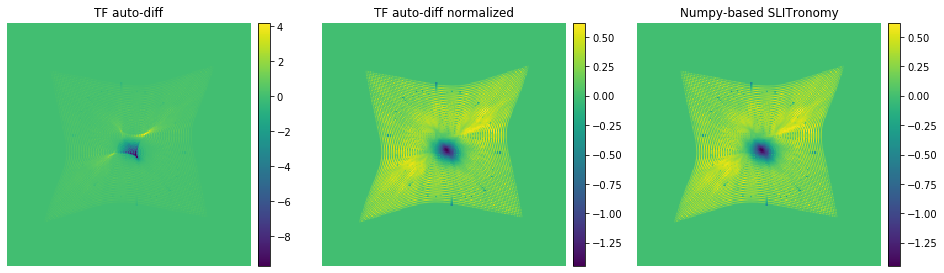

In [19]:
tf_grad_loss = modops.grad_loss(Y_tf, S=S_tf, HG=None, wrt='S')
np_grad_loss = solver.gradient_loss_source(S)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
img1 = ax1.imshow(tf_grad_loss)
nice_colorbar(img1)
ax1.set_title("TF auto-diff")
img2 = ax2.imshow(tf_grad_loss * modops.norm)
nice_colorbar(img2)
ax2.set_title("TF auto-diff normalized")
img3 = ax3.imshow(np_grad_loss)
nice_colorbar(img3)
ax3.set_title("Numpy-based SLITronomy")
for ax in (ax1, ax2, ax3):
    ax.set_axis_off()

print("Effectively equal result ?", np.allclose(tf_grad_loss * modops.norm, np_grad_loss))

## Visualise grad loss wrt HG

Effectively equal result ? True


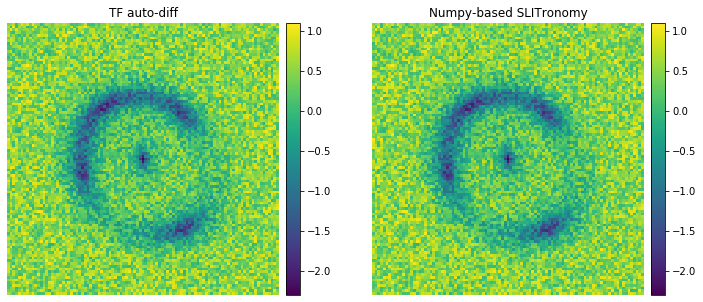

In [20]:
tf_grad_loss = modops.grad_loss(Y_tf, S=None, HG=HG_tf, wrt='HG')
np_grad_loss = solver.gradient_loss_lens(HG)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
img1 = ax1.imshow(tf_grad_loss)
nice_colorbar(img1)
ax1.set_title("TF auto-diff")
img2 = ax2.imshow(np_grad_loss)
nice_colorbar(img2)
ax2.set_title("Numpy-based SLITronomy")
for ax in (ax1, ax2):
    ax.set_axis_off()

print("Effectively equal result ?", np.allclose(tf_grad_loss, np_grad_loss))

In [21]:
psf_padded = np.zeros(HG.shape)
psf_padded[:psf_kernel.shape[0], :psf_kernel.shape[1]] = psf_kernel
psf_padded = np.pad(psf_kernel, 29)

spectrum = tf.signal.fft2d(tf.cast(psf_padded, tf.complex64))
operator = tf.linalg.LinearOperatorCirculant2D(spectrum, input_output_dtype=modops.psf_kernel.dtype)
HHG = operator.matvec(HG.flatten())